# TD 9-10

# Imports

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO

import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
url_2023 = 'https://www.data.gouv.fr/fr/datasets/r/78348f03-a11c-4a6b-b8db-2acf4fee81b1'
url_2022 = 'https://www.data.gouv.fr/fr/datasets/r/87038926-fb31-4959-b2ae-7a24321c599a'
url_2021 = 'https://www.data.gouv.fr/fr/datasets/r/817204ac-2202-4b4a-98e7-4184d154d98c'
url_2020 = 'https://www.data.gouv.fr/fr/datasets/r/90a98de0-f562-4328-aa16-fe0dd1dca60f'
url_2019 = 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2'
Liste_url = [url_2019,url_2020,url_2021,url_2022,url_2023]
df_final = pd.DataFrame()

# Chargement du fichier


Fichier 2023

In [3]:
try:
      api_request=requests.get(url_2023)
      data=api_request.text
      # Utiliser StringIO pour traiter la chaîne de caractères comme un fichier
      data_io = StringIO(data)
      # Charger le contenu dans un DataFrame pandas
      df_final = pd.read_csv(data_io, delimiter='|')
except Exception as e:
      data="Error..."

C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\328385362.py:7: DtypeWarning: Columns (14,18,23,24,26,28,29,31,32,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(data_io, delimiter='|')


# Analyse préliminaire des données

In [4]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3727005 entries, 0 to 3727004
Data columns (total 43 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Identifiant de document     float64
 1   Reference document          float64
 2   1 Articles CGI              float64
 3   2 Articles CGI              float64
 4   3 Articles CGI              float64
 5   4 Articles CGI              float64
 6   5 Articles CGI              float64
 7   No disposition              int64  
 8   Date mutation               object 
 9   Nature mutation             object 
 10  Valeur fonciere             object 
 11  No voie                     float64
 12  B/T/Q                       object 
 13  Type de voie                object 
 14  Code voie                   object 
 15  Voie                        object 
 16  Code postal                 float64
 17  Commune                     object 
 18  Code departement            object 
 19  Code commune         

In [5]:
df_final.shape

(3727005, 43)

In [6]:
(df_final.isnull().sum()/(len(data)))*100

Identifiant de document       0.749809
Reference document            0.749809
1 Articles CGI                0.749809
2 Articles CGI                0.749809
3 Articles CGI                0.749809
4 Articles CGI                0.749809
5 Articles CGI                0.749809
No disposition                0.000000
Date mutation                 0.000000
Nature mutation               0.000000
Valeur fonciere               0.006514
No voie                       0.284804
B/T/Q                         0.716660
Type de voie                  0.303080
Code voie                     0.005685
Voie                          0.005793
Code postal                   0.005735
Commune                       0.000000
Code departement              0.000000
Code commune                  0.000000
Prefixe de section            0.715165
Section                       0.000036
No plan                       0.000000
No Volume                     0.748146
1er lot                       0.518187
Surface Carrez du 1er lot

Présence de valeurs NaN et de type non exploitable, un nettoyage des données est nécessaire

# Nettoyage des données

In [7]:
# On convertit en str les colonnes souhaitées pour changer les ',' par des '.' pour ensutie les transformer
# en float

columns_to_convert = ['Valeur fonciere', 'Surface reelle bati', 'Surface terrain', 'Surface Carrez du 1er lot',
 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']

for col in columns_to_convert:
    df_final[col] = df_final[col].astype({col: str})
    df_final[col] = df_final[col].apply(lambda x: x.replace(',', '.'))
    df_final[col] = df_final[col].astype({col: np.float64})

In [8]:
# On transforme les Nan des colonnes souhaitées en 0

columns_to_convert.append('Nombre pieces principales')

df_final[columns_to_convert] = df_final[columns_to_convert].fillna(np.float64(0))

In [9]:
# Les lignes qui ont Nan pour code type local prennent alors la valeur de 5.0 pour que le trie soit plus facile après

df_final['Code type local'] = df_final['Code type local'].fillna(np.float64(5.0))

In [10]:
df_final['Date mutation'] = pd.to_datetime(df_final['Date mutation'], format='%d/%m/%Y')

In [11]:
# On supprime les mutations de nature "Echange"
df_final = df_final[df_final['Nature mutation'] != 'Echange']

# Pour réindexer le DataFrame de manière consécutive
df_final.reset_index(drop=True, inplace=True)

In [12]:
# On crée une nouvelle colonne qui contient la somme des surfaces Carrez des lots

new_column = df_final['Surface Carrez du 3eme lot'] + df_final['Surface Carrez du 4eme lot'] + df_final['Surface Carrez du 3eme lot'] + df_final['Surface Carrez du 4eme lot'] + df_final['Surface Carrez du 5eme lot']

df_final.insert(9,'Surface totale des lots', new_column)

In [13]:
# On suprrime toutes les colonnes composées entierement de valeur NaN et les colonnes inutiles

df_final = df_final.dropna(axis=1, how='all')

df_final = df_final.drop(columns=['No disposition', 'No voie', 'B/T/Q', 'Type de voie',
                                  'Code voie', 'Voie', 'Code postal', 'Commune', 'Prefixe de section',
                                  'Section', 'No plan', 'No Volume', '1er lot', 'Surface Carrez du 1er lot', '2eme lot',
                                  'Surface Carrez du 2eme lot', '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
                                  'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
                                  'Nature culture', 'Type local', 'Nature culture speciale'])

In [14]:
df_final['Nature mutation'] = df_final['Nature mutation'].astype('category').cat.codes

# on a donc :
# 'Adjudication'                          <=> 0
# 'Expropriation'                         <=> 1
# 'Vente'                                 <=> 2
# 'Vente en l'état futur d'achèvement'    <=> 3
# 'Vente terrain à bâtir'                 <=> 4

In [15]:
df_final =df_final.replace('2A',1000)#La corse du sud sera desormais 1000
df_final=df_final.replace('2B',1001)
df_final["Code departement"] = df_final["Code departement"].astype(int)

In [16]:
df_final = df_final.dropna(subset=["Valeur fonciere"])
df_final.loc[df_final["Surface terrain"].isna(), "Surface terrain"] = df_final["Surface reelle bati"] + df_final["Surface totale des lots"]

In [17]:
df_final = df_final[df_final['Nombre pieces principales']<15]
df_final = df_final[(df_final['Valeur fonciere'] > 2000) & (df_final['Valeur fonciere'] < 100000000)]
df_final = df_final[df_final['Surface reelle bati'] < 25000]
df_final = df_final[(df_final['Surface totale des lots'] + df_final['Surface reelle bati'] + df_final['Surface terrain']) != 0]

In [18]:
# On a agrégé les ensembles de mutations en regroupant les lignes qui ont des valeurs identiques de colonnes spécifiques pour ensuite prendre le maximum de chaqunes des valeurs

df_final = df_final.groupby(['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Code departement', 'Code commune']).agg({
    'Surface reelle bati': 'max',
    'Nombre pieces principales': 'max',
    'Surface terrain': 'max',
    'Nombre de lots': 'max',
    'Surface totale des lots': 'max',
    'Code type local': lambda series: 4 if 4 in series else series.min()
}).reset_index()

In [19]:
# On change de place les colonnes pour une meilleur comprehension du DataFrame

df_final = df_final[['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Code departement', 'Code commune', 'Code type local', 'Nombre pieces principales', 'Nombre de lots', 'Surface totale des lots', 'Surface reelle bati', 'Surface terrain']]

In [20]:
# On enlève les lignes qui n'ont pas de surface reelle bati

df_final = df_final[df_final['Surface reelle bati'] > 0]

In [21]:
df_final['Prix au m²'] = df_final['Valeur fonciere'] / df_final['Surface reelle bati']

# Création des features

In [22]:
df_prix_moyen_par_commune = df_final.groupby(['Code commune','Code departement'])['Prix au m²'].mean().reset_index()
df_prix_moyen_par_departement = df_final.groupby(['Code departement'])['Prix au m²'].mean().reset_index()

In [23]:
df_final=df_final.merge(df_prix_moyen_par_commune, on=['Code commune','Code departement'],how='inner')
df_final.drop(columns='Prix au m²_x',inplace=True)

In [24]:
df_final.rename(columns={'Prix au m²_y': 'Prix au m² moyen par commune'},inplace=True)
data = df_final.drop(columns=["Date mutation"])


# Affichage des données

Afin d'avoir des données lisible certaine modification on été faite

In [25]:
df_filtered = df_final[df_final['Surface totale des lots'] <= 100]
df_filtered = df_filtered[df_filtered['Valeur fonciere'] <= 2000000]
df_filtered = df_filtered[df_filtered['Valeur fonciere'] >= 100000]

df_filtered = df_filtered[df_filtered['Nombre de lots'] <= 10]
df_filtered = df_filtered[df_filtered['Surface reelle bati'] <= 150]
df_filtered = df_filtered[df_filtered['Surface reelle bati'] >= 5]
df_filtered = df_filtered[df_filtered['Code type local'] == 2]
#df_filtered = df_filtered[df_filtered['Nature mutation'] == 3]
df_filtered = df_filtered[df_filtered['Code departement'] == 75]
df_filtered=df_filtered.drop(columns=["Date mutation","Code type local","Code departement"])
df_filtered = df_filtered[df_filtered['Prix au m² moyen par commune'] <= 20000]
print(df_filtered.shape)
df_filtered.describe()

(26634, 9)


Nature mutation  Valeur fonciere  Code commune  \
count     26634.000000     2.663400e+04  26634.000000   
mean          1.997222     5.164657e+05    113.320418   
std           0.084861     3.549775e+05      4.811053   
min           0.000000     1.000000e+05    101.000000   
25%           2.000000     2.650000e+05    110.000000   
50%           2.000000     4.100000e+05    114.000000   
75%           2.000000     6.528350e+05    117.000000   
max           4.000000     2.000000e+06    120.000000   

       Nombre pieces principales  Nombre de lots  Surface totale des lots  \
count               26634.000000    26634.000000             26634.000000   
mean                    2.282984        1.667981                 0.346684   
std                     1.101777        0.752945                 4.940515   
min                     0.000000        0.000000                 0.000000   
25%                     1.000000        1.000000                 0.000000   
50%                     2.000000        2.000000                 0.000000   
75%                     3.000000        2.000000                 0.000000   
max                    12.000000       10.000000               100.000000   

       Surface reelle bati  Surface terrain  Prix au m² moyen par commune  
count         26634.000000     26634.000000                  26634.000000  
mean             48.397011         0.192386                  11004.158523  
std              27.754098         9.597604                   2037.960961  
min               5.000000         0.000000                   8885.172197  
25%              28.000000         0.000000                   9721.034067  
50%              42.000000         0.000000                  10149.728799  
75%              64.000000         0.000000                  11370.388993  
max             150.000000      1110.000000                  19143.991842

Proportion des données par features

C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\3033400489.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_filtered[j])
C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\3033400489.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_filtered[j])
C:\Users\cambo\AppData\Local\Temp\ip

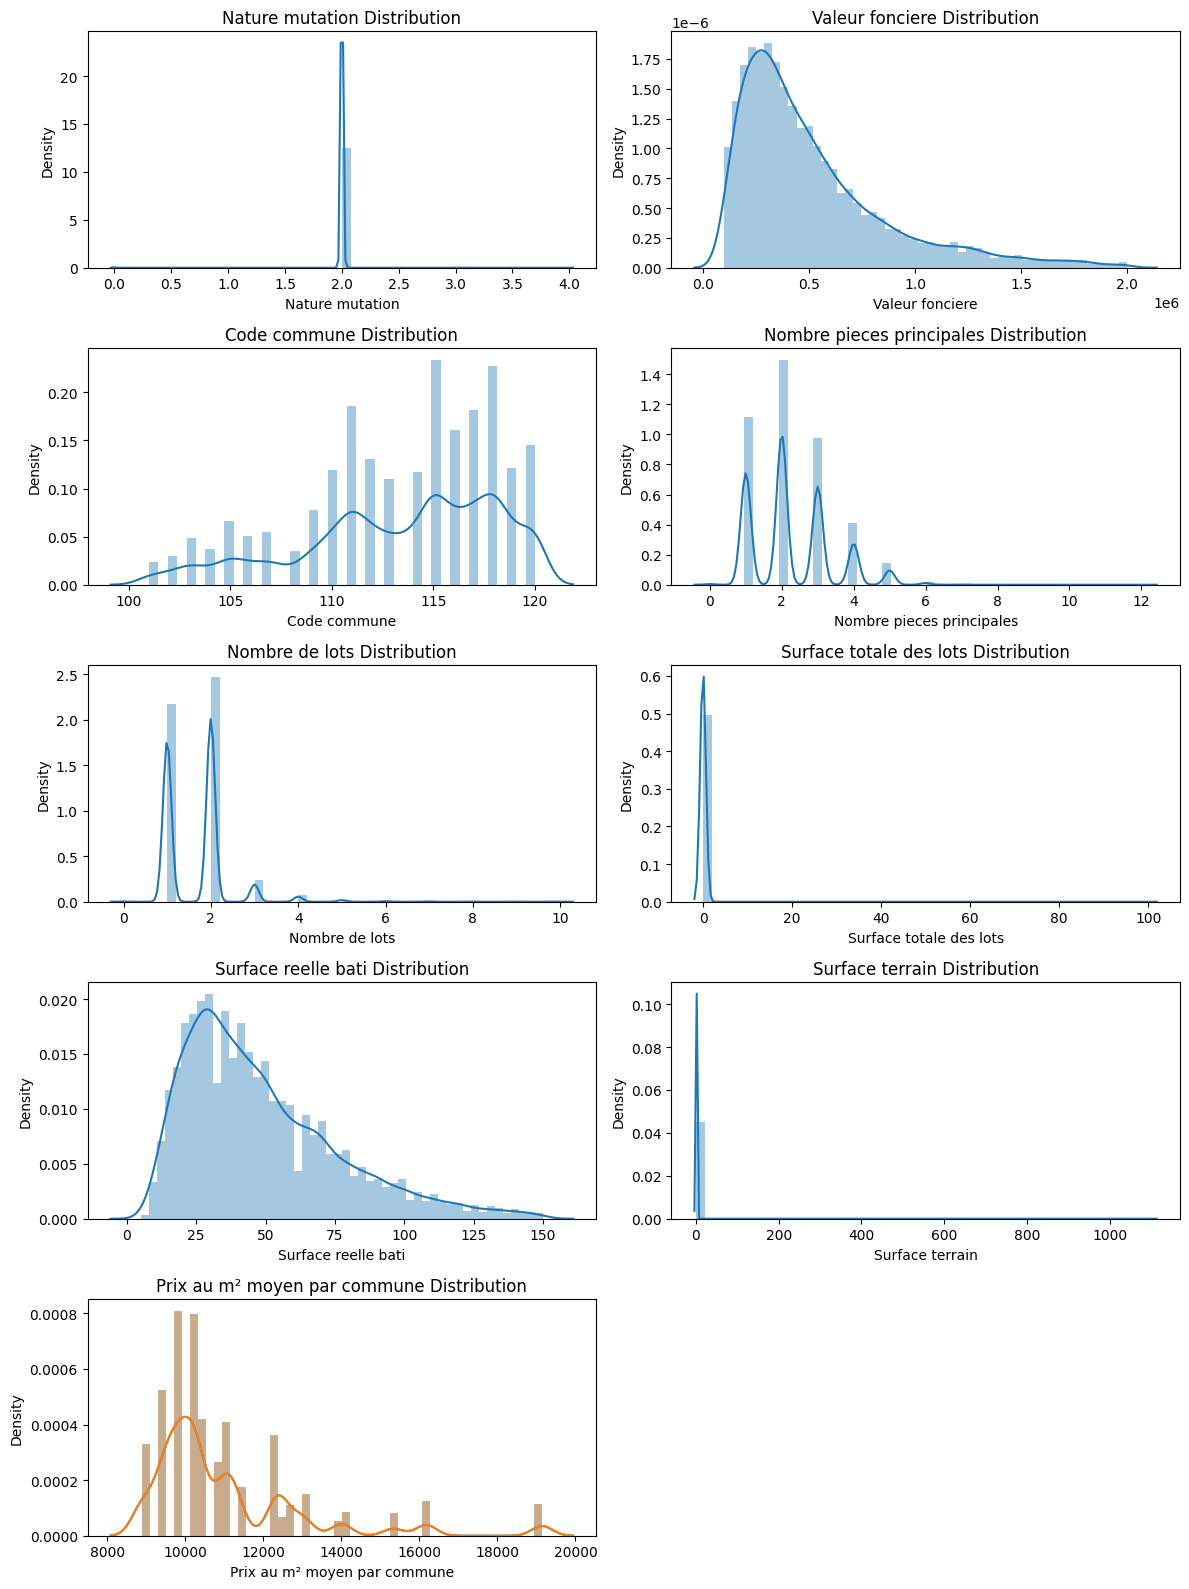

In [26]:
plt.figure(figsize=(12,16))
for i, j in enumerate(df_filtered.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df_filtered[j])
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    # plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()
sns.distplot(x=df_filtered[j])
plt.xlabel(j)
plt.title('{} Distribution'.format(j))
plt.show()

Boxplot des features

Ensemble des boxplot relativement symetrique avec présence de quelque valeurs abérante
sauf pour la valeur foncière et la surface réelle bâtie qui ont une longue queue droite, ce qui suggère une distribution asymétrique avec quelques valeurs très élevées.

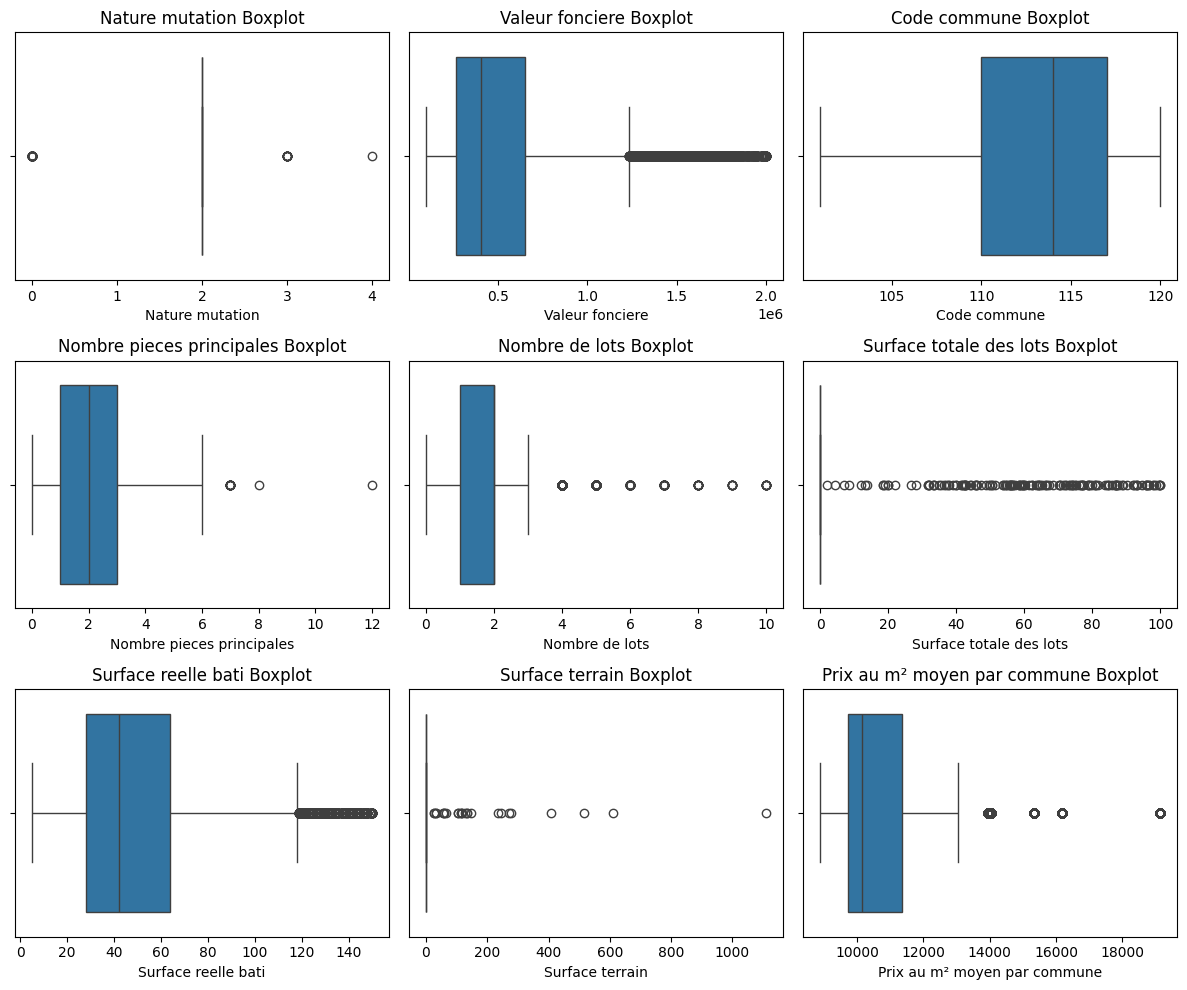

In [27]:
# Visualize the boxplot of each variable.plt.figure(figsize=(12,10))
plt.figure(figsize=(12,10))
for i, j in enumerate(df_filtered.describe().columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=df_filtered[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

Graphique mettant en évidance une proportionnalité entre la valeur fonciere et la surface reelle bati en fonction de la commune
(Nous pouvons le voir de part la présence de droite par des couleurs différentes)

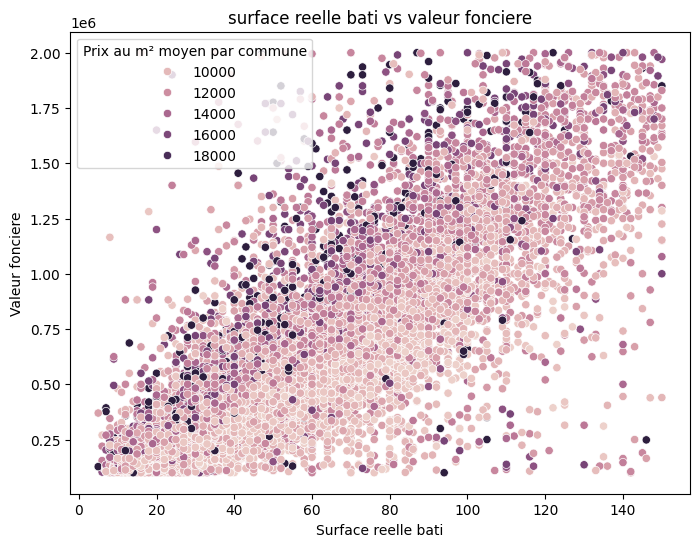

In [28]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(y=df_filtered["Valeur fonciere"], x=df_filtered["Surface reelle bati"],hue=df_filtered["Prix au m² moyen par commune"])
plt.title('surface reelle bati vs valeur fonciere')
#plt.savefig('scatter.png')
plt.show()


**Pairplot**

 Nous pouvons voir l'allure générale des features

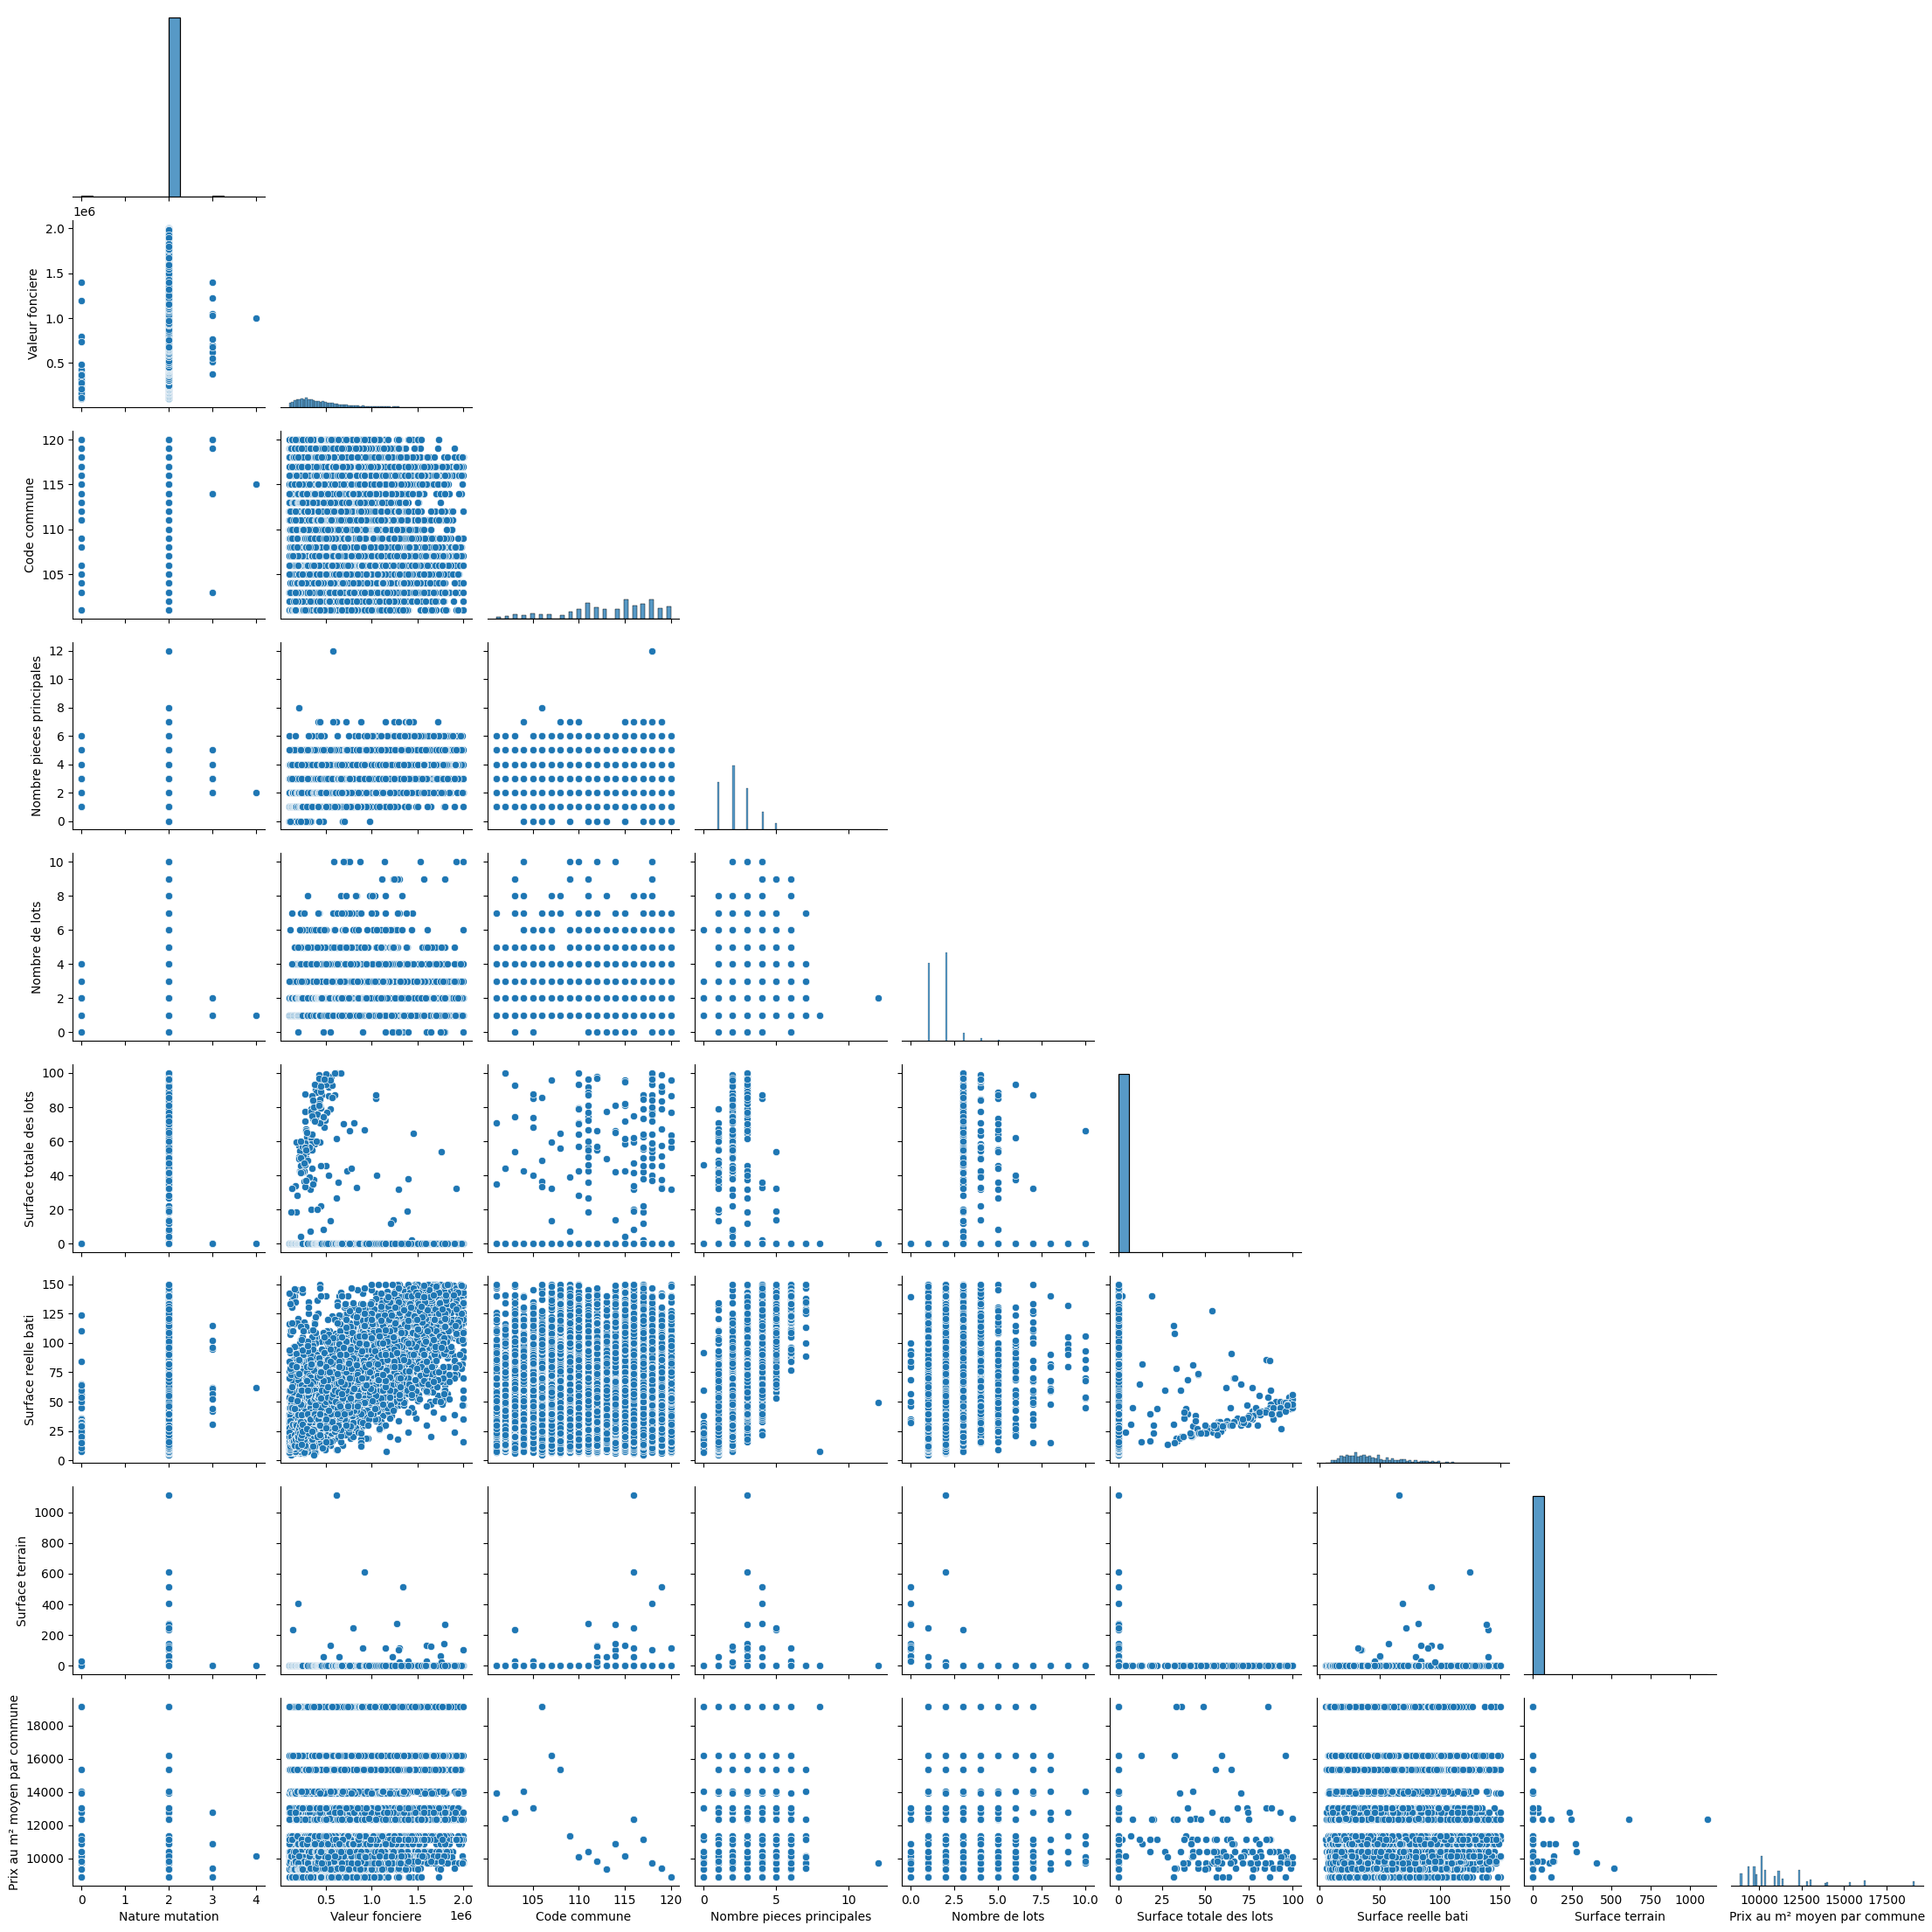

In [29]:
pairplot = sns.pairplot(df_filtered, corner=True)
plt.show(pairplot)

**Matrice de corrélation** mettant en évidence une forte corrélation entre la valeur foncière et les différent features liées à la surface notamment la surface réelle bâti

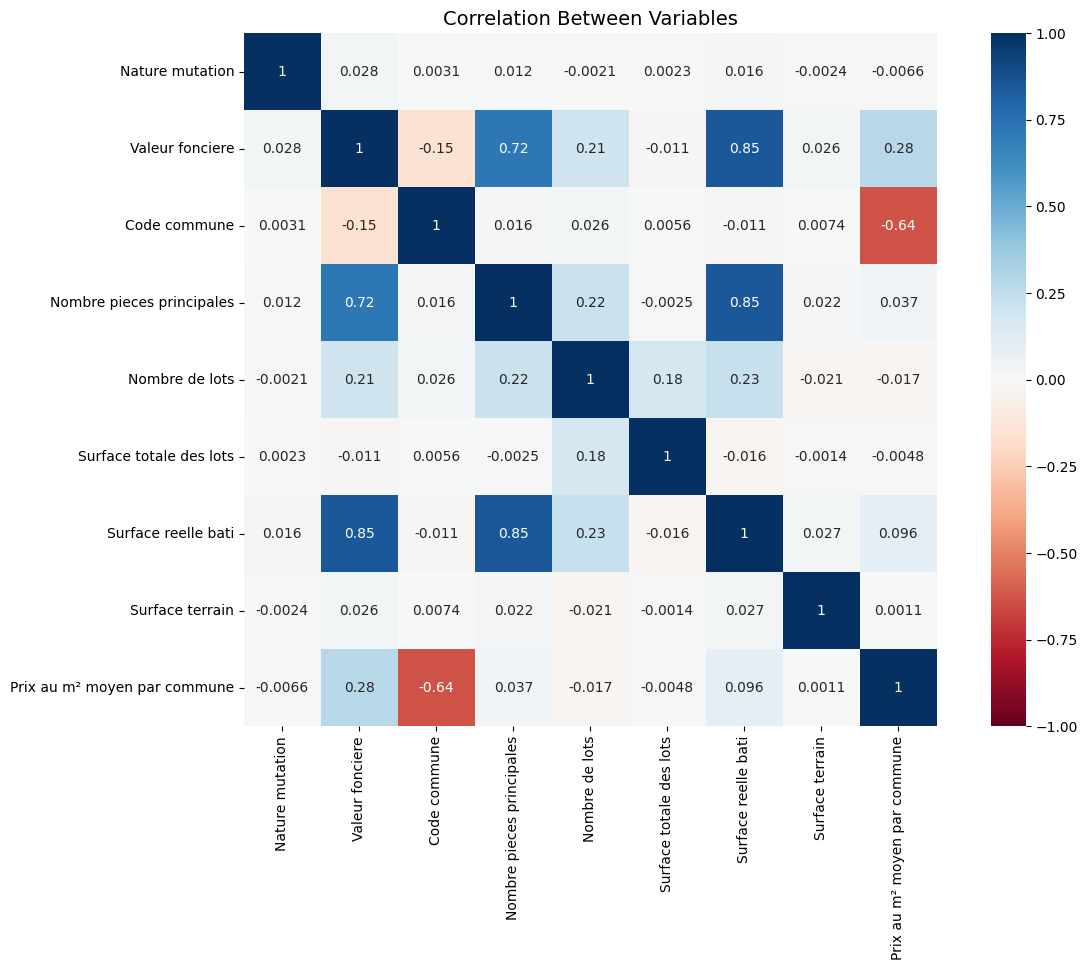

In [30]:
correlation_metrics=df_filtered.corr()
fig = plt.figure(figsize=(14,9))
sns.heatmap(correlation_metrics,square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')
plt.title('Correlation Between Variables', size=14)
plt.show()

# Calcul de l'ACP
Préparation final du dataset pui normalisation

In [31]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

# on supprime 'Date mutation car pas int'
# df_data = df_final.drop(columns=['Date mutation'])

df_data = deepcopy(df_filtered)

# on normalise data avec la méthode fit_transform() de l'instance StandardScaler()
normalized_df = StandardScaler().fit_transform(df_data)

In [32]:
df_data.head()

Nature mutation  Valeur fonciere  Code commune  \
262                2         276000.0           115   
317                2         468000.0           108   
339                2         895000.0           117   
342                2        1245161.4           116   
755                2         112000.0           118   

     Nombre pieces principales  Nombre de lots  Surface totale des lots  \
262                        2.0               1                      0.0   
317                        2.0               2                      0.0   
339                        3.0               2                      0.0   
342                        3.0               1                      0.0   
755                        1.0               1                      0.0   

     Surface reelle bati  Surface terrain  Prix au m² moyen par commune  
262                 27.0              0.0                  10149.728799  
317                 60.0              0.0                  15327.130759  
339                 89.0              0.0                  11125.594777  
342                 70.0              0.0                  12351.381776  
755                 19.0              0.0                   9721.034067

Calacul des PCA

In [33]:
from sklearn.decomposition import PCA

# On calcule les compostantes principales pour savoir lesquels on doit prendre.
pca = PCA()
pca.fit(normalized_df)

# On trouve le nombre en faisant la somme cumulée de la liste des ratios de variance expliquée de chacune des composantes principales.
# On regarde ensuite les indices qui suffient à dépasser le taux de variance expliquée minimum  à dépasser en faisant la somme de ces valeurs.
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Nombre optimal de composantes principales : {n_components}")

# On crée notre objet PCA en l'ajustant avec le nombre optimal de components
# (nombres de composantes principales, ou de vecteurs propres selctionnés)
pca = PCA(n_components=n_components)

# On alcule les composantes principales : calcul de la matrice de covariance, des valeurs et vecteurs propres,
# puis tri des compostantes principales en fonction des valeurs propres les plus élevées puis selction des n_components si donné.
pca.fit(normalized_df)

# On transforme les données normalisées en utilisant le modèle PCA ajusté. Cela projette les données
# dans le nouvel espace de dimension réduite défini par les composantes principales sélectionnées.
# projectedData contiendra les données transformées avec le nombre optimal de composantes principales.
projected_df = pca.transform(normalized_df)
print(len(projected_df[0]))

Nombre optimal de composantes principales : 6
6


Création d'un DataFrame eig pour visualiser la Variance expliquée

In [34]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(projected_df[0]))],
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100, decimals=2),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100, decimals=2)
    }
)
eig

Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            2.746204                 30.51                  30.51
1      Dim2            1.638679                 18.21                  48.72
2      Dim3            1.136426                 12.63                  61.35
3      Dim4            1.002113                 11.13                  72.48
4      Dim5            0.996172                 11.07                  83.55
5      Dim6            0.768737                  8.54                  92.09

Graphique mettant en valeur le ratio de variance expliquée par composante principale

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Dim1'),
  Text(1, 0, 'Dim2'),
  Text(2, 0, 'Dim3'),
  Text(3, 0, 'Dim4'),
  Text(4, 0, 'Dim5'),
  Text(5, 0, 'Dim6')])

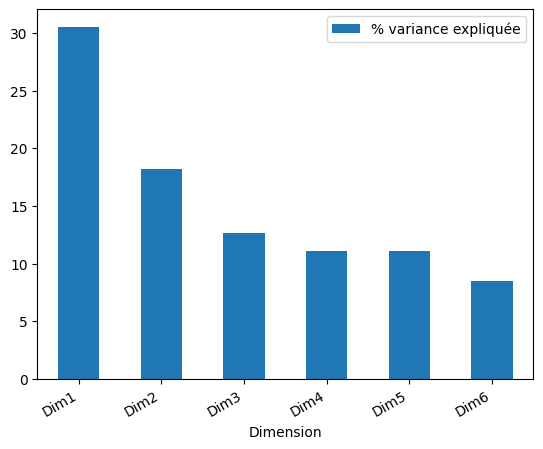

In [35]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée")
plt.xticks(rotation=30, ha='right')


# Apprentissage non supervisé et clustering avec K-means
On applique ici la méthode du coude pour trouver le nombre de cluster optimal

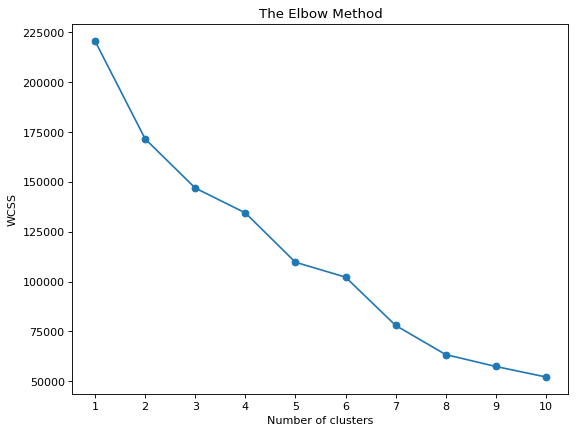

In [36]:
import sklearn.cluster as skc

wcss=[]
k_range = range(1,11)
for i in k_range:
    kmeans = skc.KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(projected_df)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
plt.plot(k_range, wcss, marker='o')

plt.xticks(k_range)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [37]:
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")

kl.elbow

7

On applique l'algorithme des K-means avec kl.elbow clusters

In [38]:
kmeans = skc.KMeans(n_clusters=kl.elbow, random_state=42)
clusters = kmeans.fit_predict(projected_df)

print(clusters)

[2 1 0 ... 3 3 3]


On affiche les moyennes de chaque colonne par cluster

In [41]:
df_data.groupby(clusters).mean()

Nature mutation  Valeur fonciere  Code commune  Nombre pieces principales  \
0         2.001087     6.626677e+05    115.041608                   3.107281   
1         2.000000     5.078372e+05    104.781493                   1.862785   
2         2.000436     2.759358e+05    114.855504                   1.529044   
3         2.001502     1.279638e+06    111.715359                   4.220053   
4         2.000000     4.391296e+05    113.674419                   2.147287   
5         2.000000     3.352528e+05    115.061268                   1.741788   
6         0.000000     3.127182e+05    113.409091                   2.022727   

   Nombre de lots  Surface totale des lots  Surface reelle bati  \
0        1.734203                 0.006996            66.461419   
1        1.509657                 0.023551            38.957625   
2        0.999855                 0.000000            28.386146   
3        2.055952                 0.037086           105.083365   
4        3.620155                67.977674            40.077519   
5        2.159383                 0.034125            34.785347   
6        1.613636                 0.000000            39.613636   

   Surface terrain  Prix au m² moyen par commune  
0         0.071107                  10306.682588  
1         0.009513                  14729.087258  
2         0.016555                  10225.883263  
3         1.684566                  12108.650332  
4         0.000000                  10853.600822  
5         0.000000                  10147.289347  
6         0.750000                  11182.030629

Pairplot de chacune des composante principales avec les autres

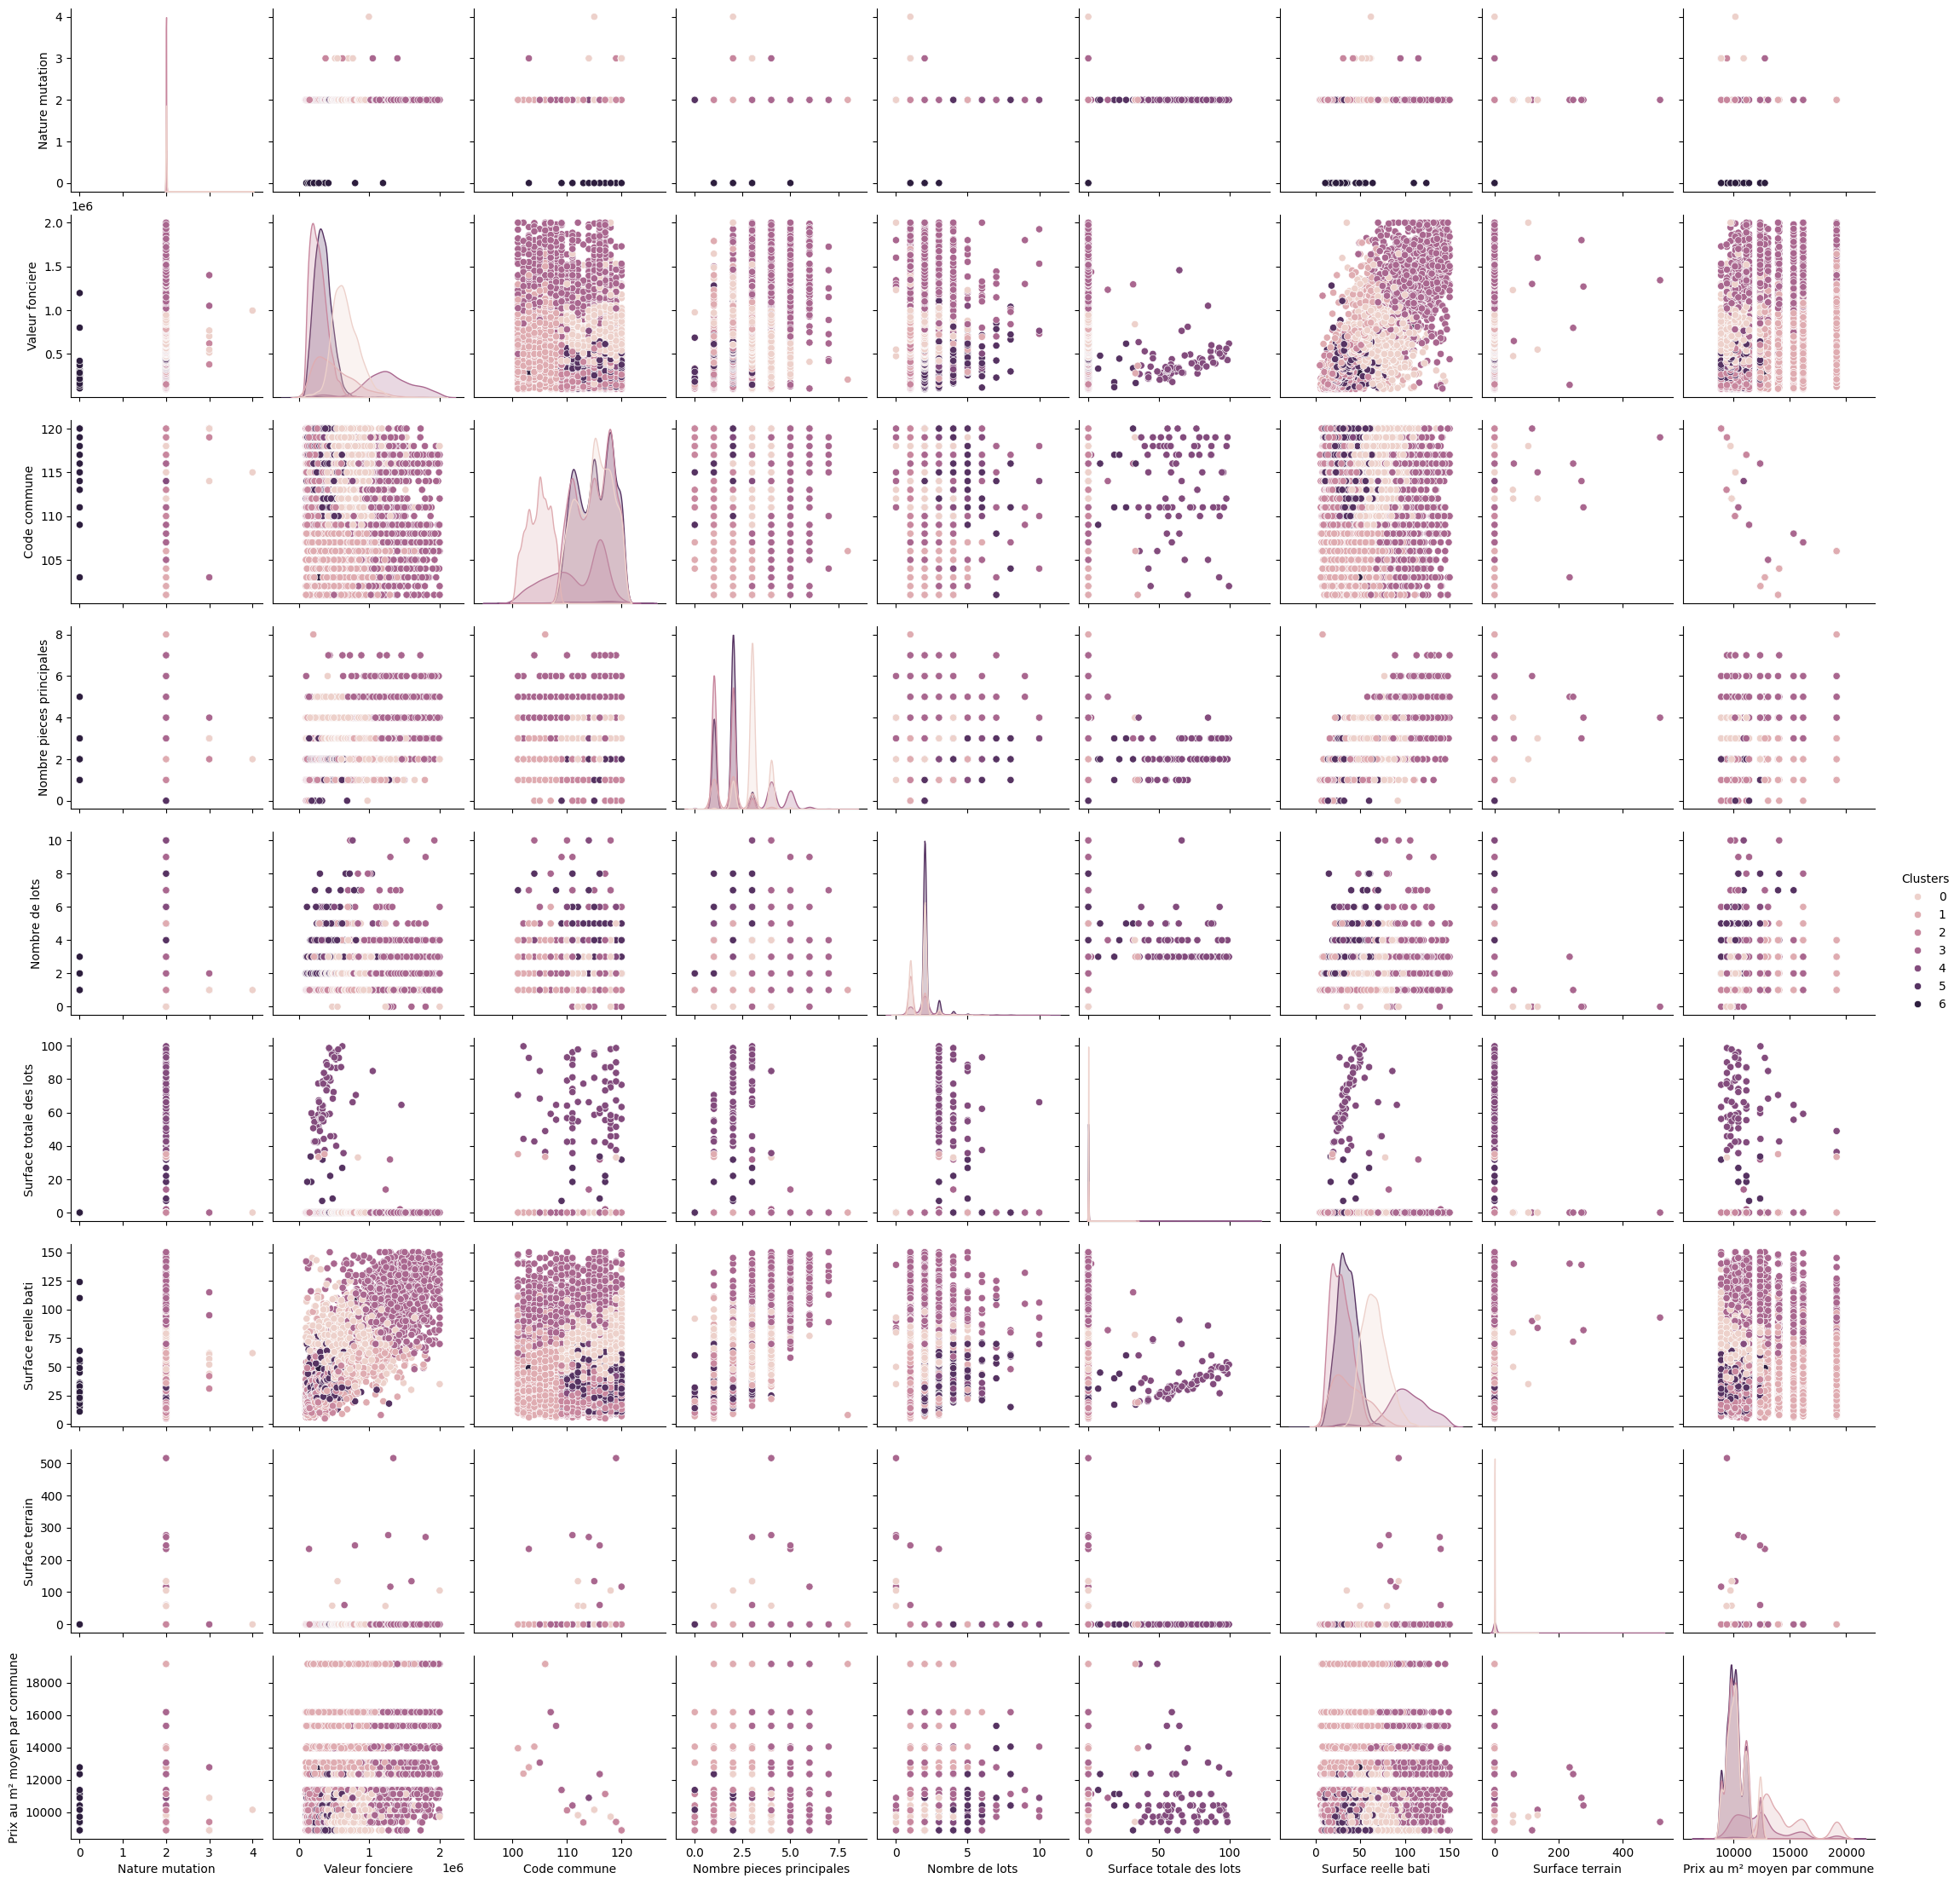

In [42]:
import seaborn as sns


df_data['Clusters'] = clusters

df_pairplot = df_data.iloc[:15000, :]

sns.pairplot(df_pairplot, hue="Clusters")

boxplot des composantes principales en fonction des clusters

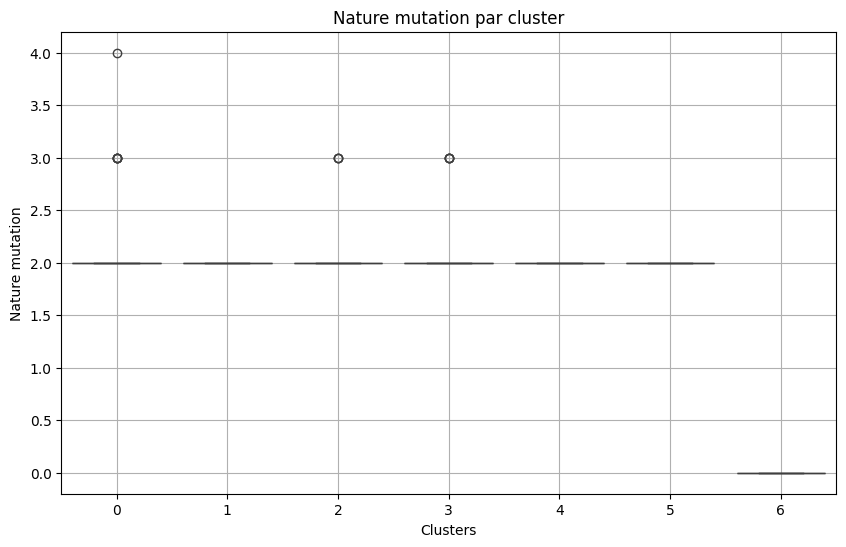

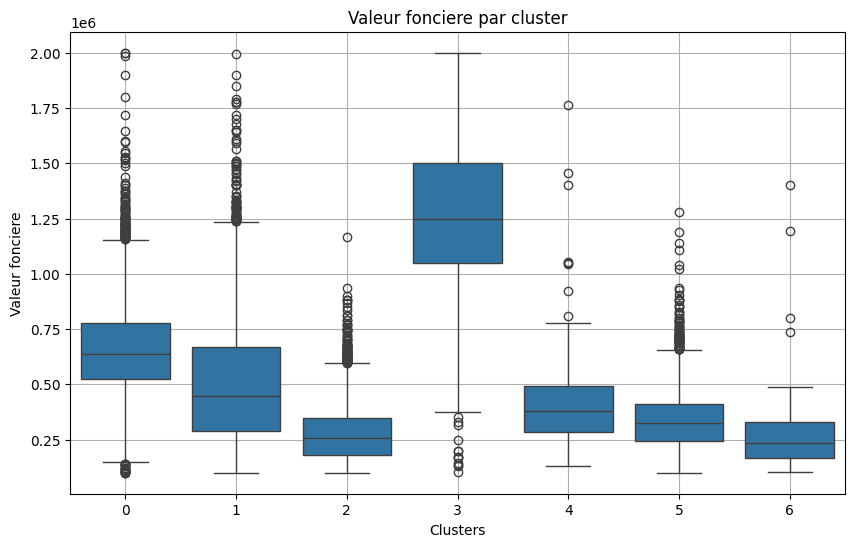

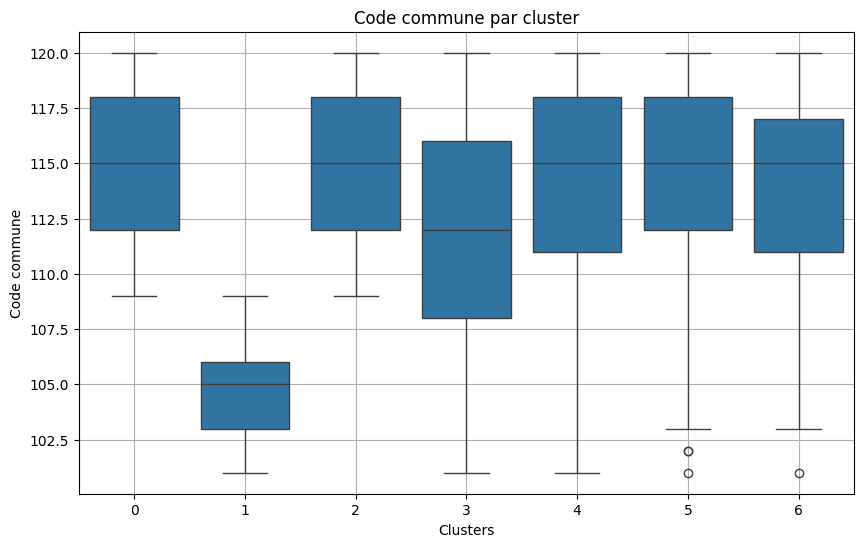

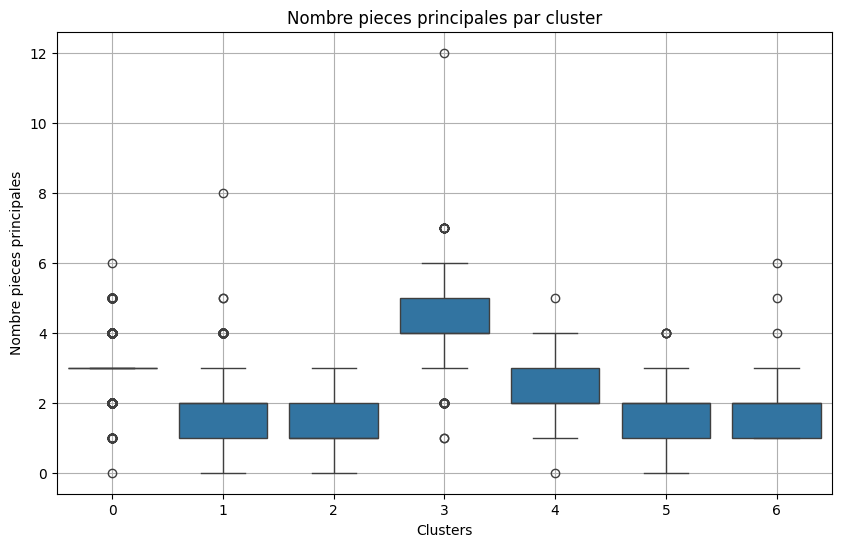

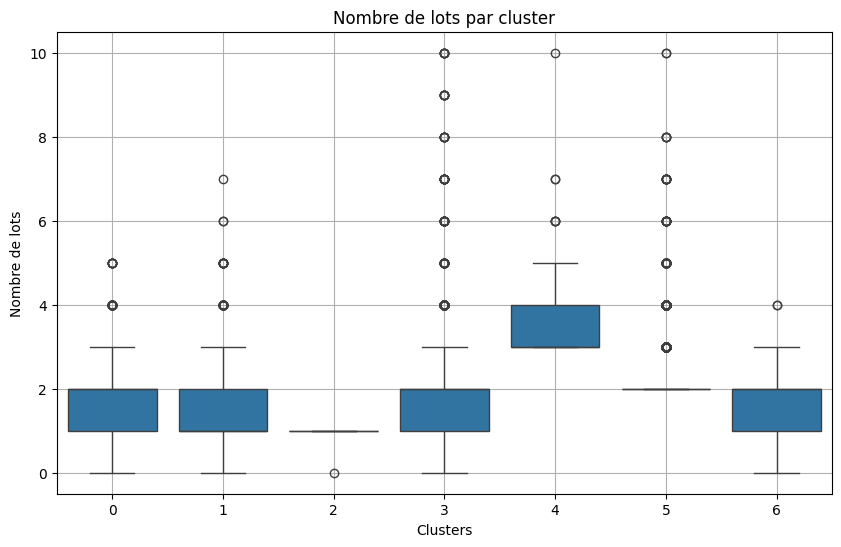

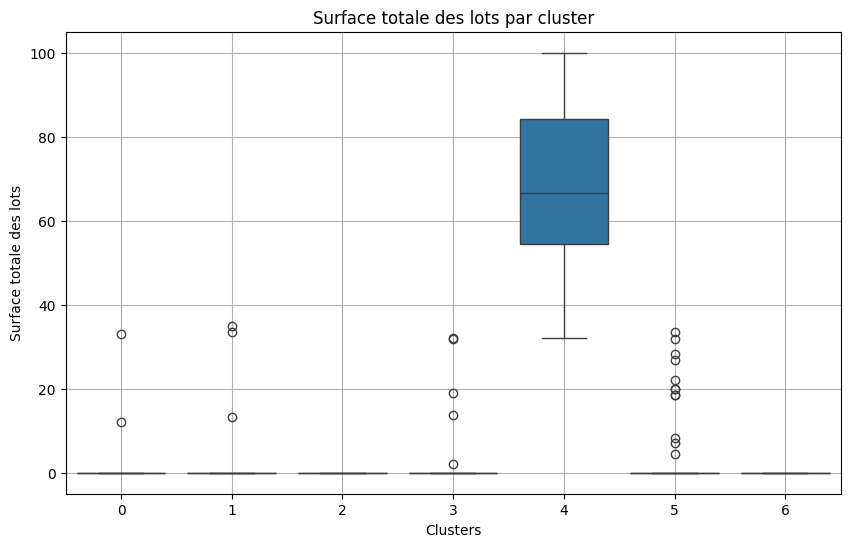

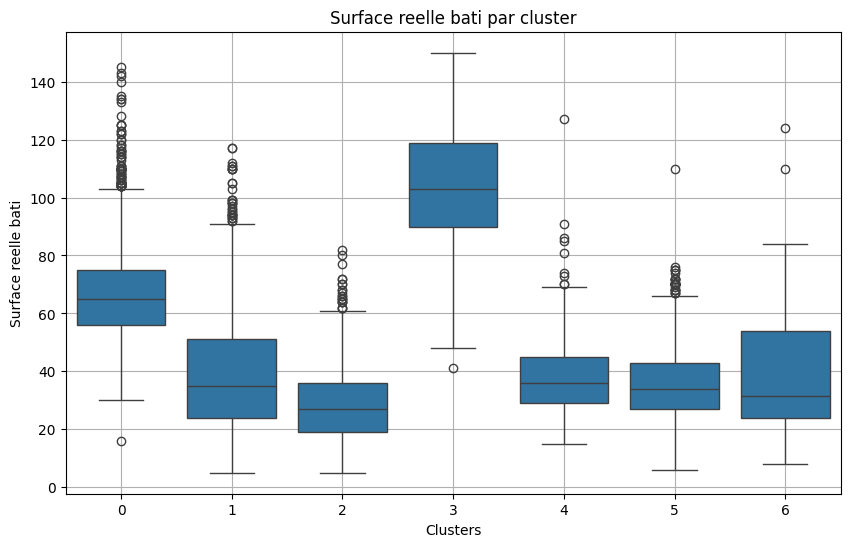

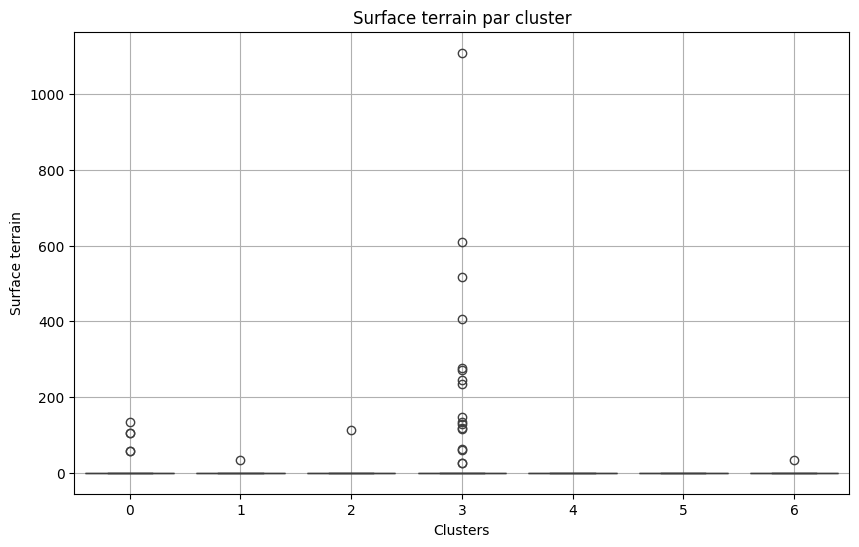

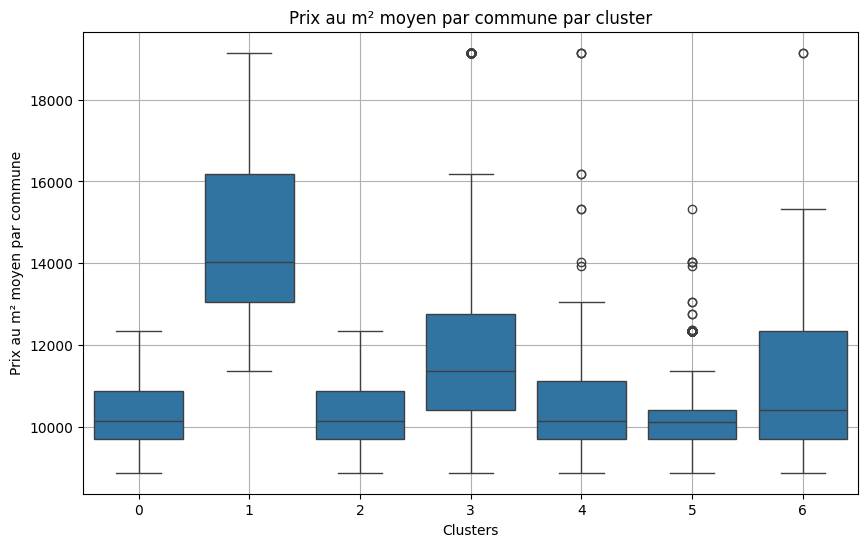

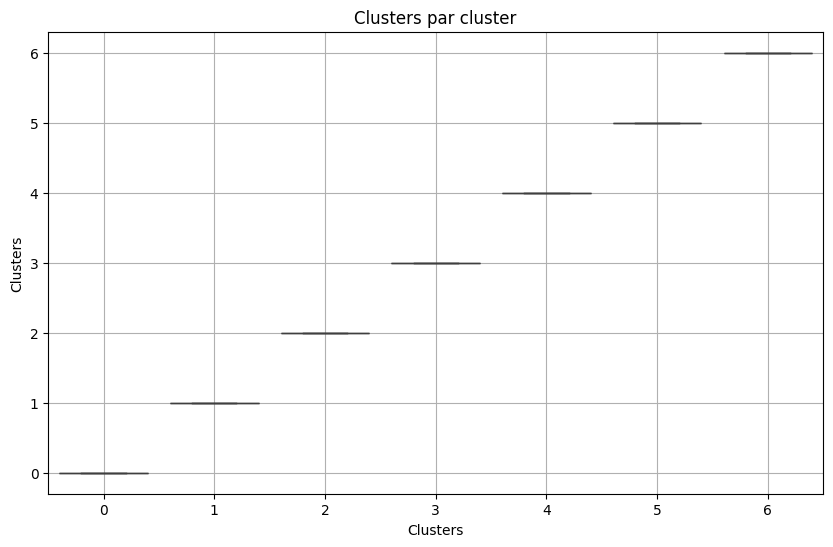

In [43]:
for column in df_data.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Clusters', y=column, data=df_data)
    plt.title(f"{column} par cluster")
    plt.grid(True)
    plt.show

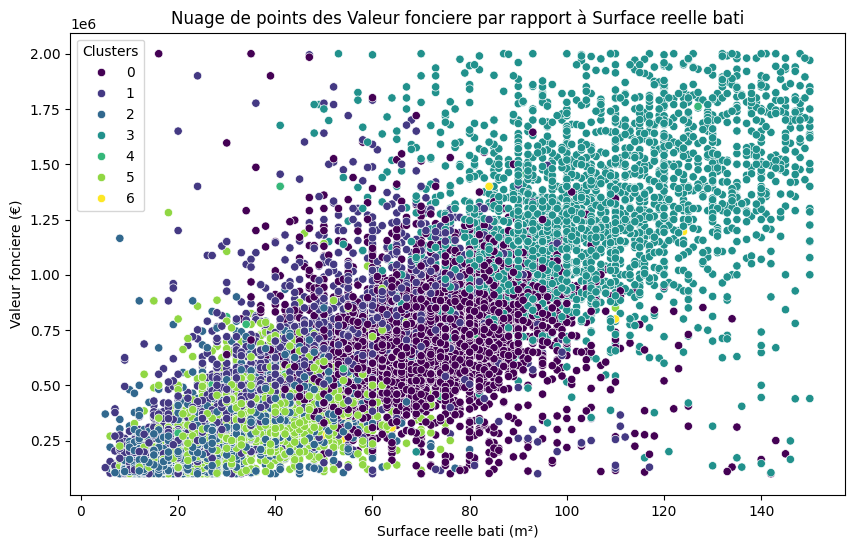

In [44]:
# Assumons que ton DataFrame s'appelle df_data
# df_data contient les colonnes 'Valeur fonciere', 'Surface reelle bati', et 'Clusters'

# Création du nuage de points
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=df_data,
    x='Surface reelle bati',
    y='Valeur fonciere',
    hue='Clusters',
    palette='viridis',  # Palette de couleurs
    legend='full'  # Affiche la légende complète
)

# Ajout des titres et des étiquettes
plt.title('Nuage de points des Valeur fonciere par rapport à Surface reelle bati')
plt.xlabel('Surface reelle bati (m²)')
plt.ylabel('Valeur fonciere (€)')
plt.legend(title='Clusters')

# Affichage du graphique
plt.show()

## Apprentissage supervisé : régression linéaire

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
scaler_X_test = StandardScaler()
scaler_X_train = StandardScaler()
scaler_Y_test = StandardScaler()
scaler_Y_train = StandardScaler()
code_departement =75
data= data[((data['Valeur fonciere']/data['Surface reelle bati'])>(data['Prix au m² moyen par commune']-2000))&((data['Valeur fonciere'])/(data['Surface reelle bati'])<(data['Prix au m² moyen par commune']+2000))]
data=data[(data['Nature mutation']==2)|(data['Nature mutation']==3)]
data=data[(data['Code departement']==code_departement)&((data['Code type local']==2)|(data['Code type local']==1))&(data['Surface reelle bati']>20)&(data['Valeur fonciere']>10000)&(data['Valeur fonciere']<10000000)&(data['Surface totale des lots']>20)]
data=data.drop(columns=['Code departement'])


In [47]:
X_data =data.drop(columns=["Valeur fonciere"])
Y_data = data[['Valeur fonciere']]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.25)
X_train_normalized = scaler_X_train.fit_transform(X_train)
X_test_normalized = scaler_X_test.fit_transform(X_test)
y_train_normalized = scaler_Y_train.fit_transform(y_train)
y_test_normalized = scaler_Y_test.fit_transform(y_test)

In [49]:
model = LinearRegression()
model.fit(X_train_normalized, y_train_normalized)
y_train_pred_normalized = model.predict(X_train_normalized)
y_test_pred_normalized = model.predict(X_test_normalized)

In [50]:
train_mse = mean_squared_error(y_train_normalized, y_train_pred_normalized)
test_mse = mean_squared_error(y_test_normalized, y_test_pred_normalized)
train_r2 = r2_score(y_train_normalized, y_train_pred_normalized)
test_r2 = r2_score(y_test_normalized, y_test_pred_normalized)

In [51]:
y_pred = scaler_Y_train.inverse_transform(y_train_pred_normalized)
ecart_moyen_train = np.abs(y_train-y_pred).mean()

y_pred_test = scaler_Y_test.inverse_transform(y_test_pred_normalized)
ecart_moyen_test = np.abs(y_test-y_pred_test).mean()

In [52]:
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')


print("L'écart moyen entre les prédictions et les valeurs réelles de train est de:",ecart_moyen_train)
print("L'écart moyen entre les prédictions et les valeurs réelles de test est de:",ecart_moyen_test)

Train MSE: 0.05
Test MSE: 0.07
Train R^2: 0.9494711961829092
Test R^2: 0.9303677545192166
L'écart moyen entre les prédictions et les valeurs réelles de train est de: Valeur fonciere    114104.052485
dtype: float64
L'écart moyen entre les prédictions et les valeurs réelles de test est de: Valeur fonciere    105531.281841
dtype: float64


Visualisation des valeurs réelles et prédites

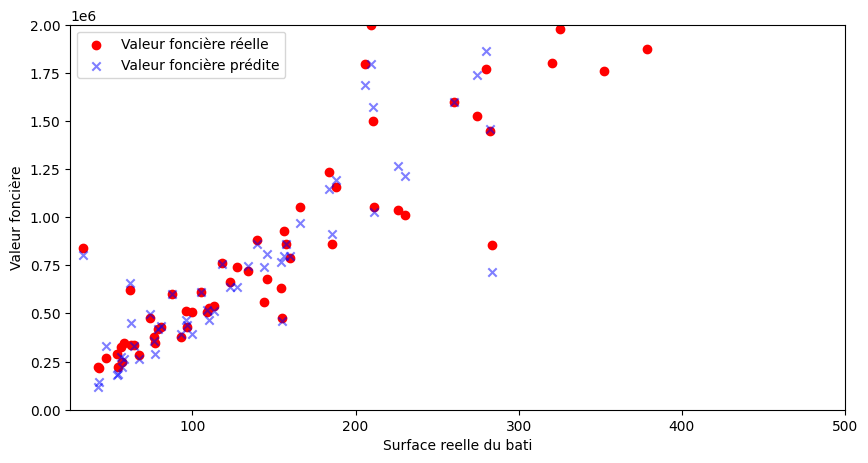

In [53]:
plt.figure(figsize=(10, 5))
# Tracer les valeurs prédites
plt.scatter(X_test.iloc[:,5], y_test, c='red', label='Valeur foncière réelle',marker='o')
plt.scatter(X_test.iloc[:,5],y_pred_test , c='blue', label='Valeur foncière prédite',marker='x',alpha=0.5)
plt.xlim(25, 500)
plt.ylim(0, 2000000)
plt.xlabel("Surface reelle du bati")
plt.ylabel("Valeur foncière")
plt.legend()

# Régression à l'échelle d'une commune

In [54]:
code_commune = 112 #A entrer
data_communes = data[data['Code commune']==code_commune]
data_communes.drop(columns='Code commune',inplace=True)

C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\2332024202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_communes.drop(columns='Code commune',inplace=True)


In [55]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_data =data_communes.drop(columns=["Valeur fonciere"])
Y_data = data_communes[['Valeur fonciere']]
X_normalized = X_scaler.fit_transform(X_data)
Y_normalized = Y_scaler.fit_transform(Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y_normalized, test_size = 0.25)

In [56]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [57]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [58]:
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Train MSE: 0.01
Test MSE: 0.12
Train R^2: 0.9916722867772705
Test R^2: 0.8903224702355894


# Conclusion

Nous pouvons en conclure que la prédiction est correcte à 87% pour Paris 12ème, ce qui est un modèle prédictif relativement précis.

# Visualisation des résultats sur la carte de la France

In [59]:
import geoviews as gv
import geopandas as gpd
from geoviews import dim
from bokeh.io import show
import holoviews as hv
from bokeh.models import HoverTool, ColorBar
from bokeh.palettes import Inferno256

Enable the bokeh extension

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
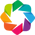

In [60]:
gv.extension('bokeh')

Load the GeoJSON file containing the geographical boundaries of French communes

In [61]:
geojson_url = "departements.geojson"
geo_df = gpd.read_file(geojson_url)

Print the column names to identify the department code column

In [62]:
print(geo_df.columns)

Index(['code', 'nom', 'geometry'], dtype='object')


Replace '2A' with 1000 and '2B' with 1001 to match the numerical department codes

In [63]:
geo_df['code'] = geo_df['code'].replace({'2A': 1000, '2B': 1001}).astype(int)

Ensure the column names match for merging

In [64]:
geo_df = geo_df.rename(columns={'code': 'Code departement'})

Ensure Code departement in geo_df is of type int

In [65]:
geo_df['Code departement'] = geo_df['Code departement'].astype(int)

Merge geographical data with the average price data

In [66]:
merged_df = geo_df.merge(df_prix_moyen_par_departement, on='Code departement')

Create a geoviews Polygons object

In [67]:
polygons = gv.Polygons(merged_df, vdims=['Prix au m²', 'Code departement'])

Calculate centroids for labels


In [68]:
merged_df['centroid'] = merged_df.geometry.centroid
merged_df['centroid_x'] = merged_df.centroid.x
merged_df['centroid_y'] = merged_df.centroid.y

choropleth = polygons.opts(
    width=1000, height=800,
    color='Prix au m²',
    colorbar=True,
    tools=['hover'],
    aspect='equal',
    cmap='Inferno',
    line_color='black',
    line_width=0.5,
    title="Average Property Prices per Square Meter by Department in France (2023)",
    colorbar_opts={'title': 'Price per m²'},
    hover_line_color='red',
    hover_fill_color='blue',
    hover_line_width=2,
    hover_alpha=0.6
)

C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\1273815297.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_df['centroid'] = merged_df.geometry.centroid
C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\1273815297.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_df['centroid_x'] = merged_df.centroid.x
C:\Users\cambo\AppData\Local\Temp\ipykernel_3180\1273815297.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_df['centroid_y'] = merged_df.centroid.y


Display the plot


In [69]:
show(gv.render(choropleth))

# Bonus : comparaison avec une autre année

Effectivement de parrt différents faceteurs tels que l'inflation, la demande, l'offre, les taux d'intérêt, les politiques publiques, les événements géopolitiques, etc. les prix de l'immobilier ont grimpés en 2023 par rapport à 2022

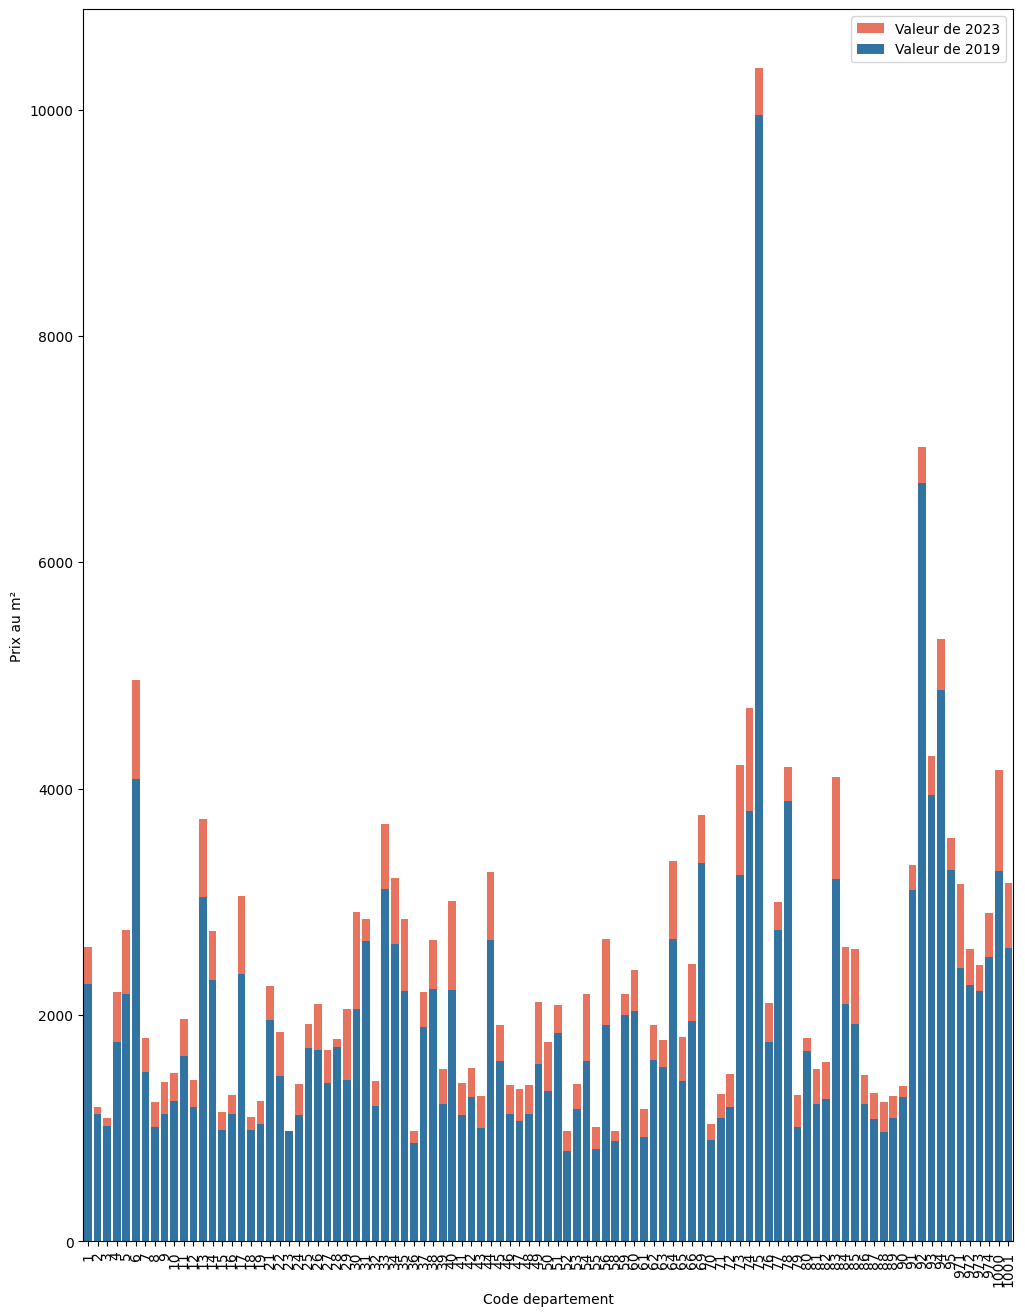

In [70]:
# chosen_color = '#FF6347' 
# df_prix_moyen_par_departement.shape

# plt.figure(figsize=(12,16))
# sns.barplot(x=df_prix_moyen_par_departement["Code departement"],y=df_prix_moyen_par_departement["Prix au m²"],color=chosen_color,label='Valeur de 2023')
# sns.barplot(x=ddf_prix_moyen_par_departement["Code departement"],y=ddf_prix_moyen_par_departement["Prix au m²"],label='Valeur de 2019')
# plt.legend(loc='upper right')
# plt.xticks(rotation=90)
# plt.show()